# 데이터 가져오기

In [1]:
import pymysql
import os
import pandas as pd
import configparser
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

today = datetime.today().strftime('%Y%m%d')
config = configparser.ConfigParser(os.environ)
config.read('./config/config.cfg')

# DB 연결
def conn_maria():
    conn = pymysql.connect(host=config['mariadb']['host'],
                          user=config['mariadb']['user'],
                          password=config['mariadb']['password'],
                          db=config['mariadb']['db'],
                          charset=config['mariadb']['charset'])
    return conn

conn = conn_maria()

'''
auction : 국산 지육 데이터
dates = 1년 365일 날짜 데이터

#############################################################################################
# dates_query where 절에서의 {} 안의 날짜는 리포트 제공날짜의 마지막 날짜(금요일)로 지정해줘야 함. 
config/dbinfo.cfg의 base_date : 회차당 마지막 날짜
#############################################################################################

'''

with conn.cursor() as cursor:
    auction_query = f'''
    SELECT date, auctCnt, sumWeight, auctAmt
    FROM {config['mariadb']['tb_auction']}
    WHERE date >= 20200101 and gradeNm = "excluded_offGrade"
    '''
    cursor.execute(auction_query)
    auction = cursor.fetchall()
    print('auction data fetch success')
    
    dates_query = f'''
    SELECT date
    FROM {config['mariadb']['tb_date']}
    WHERE date between 20200102 and {config['values']['base_date']}
    '''
    cursor.execute(dates_query)
    dates = cursor.fetchall()
    print('whole dates data fetch success')
    

tmp_train = pd.DataFrame(auction, columns=['date','auctCnt','sumWeight','auctAmt'])
real_df_train = pd.DataFrame(dates, columns=['date'])
real_df_train = real_df_train.reindex(columns = real_df_train.columns.tolist() + ["auctCnt","sumWeight",'auctAmt'])

auction data fetch success
whole dates data fetch success


In [2]:
# 실제가격 데이터, 전체날짜 데이터
tmp_train['date'] = tmp_train['date'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
tmp_train[['date','auctAmt']].to_csv('./data/korea/real.csv',index=False, encoding='euc-kr')
tmp_train['date'] = tmp_train['date'].apply(lambda x: x.replace('-',''))
tmp_train, real_df_train

(         date  auctCnt  sumWeight  auctAmt
 0    20200102     3326     292963     2898
 1    20200103     2713     236829     2910
 2    20200104       79       7342     2973
 3    20200106     2891     256686     2964
 4    20200107     2939     262280     3077
 ..        ...      ...        ...      ...
 896  20230626     2089     177430     5495
 897  20230627     1825     153739     5411
 898  20230628     1755     150574     5551
 899  20230629     1771     150635     5395
 900  20230630     1037      86324     5089
 
 [901 rows x 4 columns],
           date  auctCnt  sumWeight  auctAmt
 0     20200102      NaN        NaN      NaN
 1     20200103      NaN        NaN      NaN
 2     20200104      NaN        NaN      NaN
 3     20200105      NaN        NaN      NaN
 4     20200106      NaN        NaN      NaN
 ...        ...      ...        ...      ...
 1271  20230626      NaN        NaN      NaN
 1272  20230627      NaN        NaN      NaN
 1273  20230628      NaN        NaN     

# 분석 날짜 통합

In [3]:
'''
실제 가격 데이터는 실제가격이 있는 날짜(평일 + 간헐적 주말)만 있기 때문에
위에 선언한 real_df_train 데이터프레임과 합쳐줘야 함.
마지막에 선언된 all_day_real_price 데이터프레임은 추후에 prophet 예측에 쓰일 예정
'''

import copy

all_day_real_price = copy.deepcopy(real_df_train)

korea_date = tmp_train['date'].astype('int').tolist()
dates_list = all_day_real_price['date'].astype('int').tolist()
idx_list = []

for date in korea_date:
    if date in dates_list:
        idx = dates_list.index(date)
        idx_list.append(idx)
for i, index in enumerate(idx_list):
    all_day_real_price.iloc[index] = tmp_train.iloc[i]

all_day_real_price['date'] = dates_list
all_day_real_price

,date,auctCnt,sumWeight,auctAmt
0,20200102,3326.0,292963.0,2898.0
1,20200103,2713.0,236829.0,2910.0
2,20200104,79.0,7342.0,2973.0
3,20200105,NaN,NaN,NaN
4,20200106,2891.0,256686.0,2964.0
...,...,...,...,...
1271,20230626,2089.0,177430.0,5495.0
1272,20230627,1825.0,153739.0,5411.0
1273,20230628,1755.0,150574.0,5551.0
1274,20230629,1771.0,150635.0,5395.0


# 이상치 제거

### df_clean : 날짜 통합 전 이상치 제거한 실제 가격만 있는 dataframe
### df_realtrain : 날짜 통합 후 이상치 제거한 전체  날짜 데이터 dataframe

In [4]:
'''
interpolate 라는 내장함수는 보간법을 의미함
값이 비어있는 날짜에 대해 앞, 뒤 값의 중간값으로 자동으로 채워주는 메소드
'''


import numpy as np

# tmp_train은 실제가격만 있는 날짜들의 데이터
df_train = copy.deepcopy(tmp_train)
df_train = df_train
df_train['date'] = df_train['date'].astype('str')
df_train['date'] = df_train['date'].apply(lambda x: x.replace('-',''))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       901 non-null    object
 1   auctCnt    901 non-null    int64 
 2   sumWeight  901 non-null    int64 
 3   auctAmt    901 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.3+ KB


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       901 non-null    object
 1   auctCnt    901 non-null    int64 
 2   sumWeight  901 non-null    int64 
 3   auctAmt    901 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.3+ KB


In [6]:
# 이상치 제거 -> iqr 기법 사용
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    
    return np.where((data > upper_bound)|(data < lower_bound)), lower_bound, upper_bound

# 경락두수, 거래중량 대상으로 이상치 제거 // 실제가격에 대해서 하지 않는 이유는 실험해봤을 때 너무 많은 이상치로 삭제가 되는 부작용때문
cnt, low_cnt, up_cnt = outliers_iqr(df_train['auctCnt'])
weight, low_wgt, up_wgt = outliers_iqr(df_train['sumWeight'])

print(f'경락두수 이상치 범위 : {low_cnt} 미만 | {up_cnt} 초과')
print(f'거래중량 이상치 범위 : {low_wgt} 미만 | {up_wgt} 초과')

indexes = sorted(set(cnt[0].tolist() + weight[0].tolist()))

lead_not_outlier_index = []
for i in df_train.index:
    if i not in indexes:
        lead_not_outlier_index.append(i)

df_clean = df_train.loc[lead_not_outlier_index]
df_clean = df_clean.reset_index(drop=True)

# 육안검수로 제외할 날짜들
excld_dates = [20200122, 20200128, 20200129, 20200130, 20200131, 20200207, 20200316, 20200317, 20200508, 20200515, 20200522, 20200605, 20200626, 20200731, 20200814, 20200820, 20200821, 20200824, 20200911, 20200926, 20200928, 20201008, 20201023, 20201030, 20201127, 20201224, 20201230, 20201231, 20210122, 20210205, 20210312, 20210319, 20210409, 20210505, 20210507, 20210519, 20210719, 20210730, 20210813, 20210911, 20210916, 20210924, 20211015, 20211201, 20211213, 20220105, 20220204, 20220318, 20220325, 20220429, 20220513, 20220527, 20220606, 20220610, 20220624, 20220701, 20220708, 20220715, 20220729, 20220812, 20220907, 20220908, 20220913, 20220916, 20221014, 20221021, 20221202, 20221216, 20221223, 20221230, 20230119, 20230203, 20230511, 20230512, 20230519, 20230526,]

real_index = []
for i in df_clean.index:
    if int(df_clean['date'][i]) not in excld_dates:
        real_index.append(i)

df_clean = df_clean.loc[real_index]

# 빈 날짜 채우기
date_list = real_df_train.drop_duplicates(subset=['date'])['date'].tolist()
df_date = pd.DataFrame(date_list, columns=['date'])
df_date = df_date.reindex(columns = df_date.columns.tolist() + ['auctCnt','sumWeight','auctAmt'])
dates = df_clean['date'].tolist()

idx_list = []
for date in dates:
    if date in date_list:
        idx = date_list.index(date)
        idx_list.append(idx)
for i, index in enumerate(idx_list):
    df_date.iloc[index] = df_clean.iloc[i]

df_date['date'] = date_list
df_realtrain = df_date.interpolate()

df_clean = df_clean.reset_index(drop=True)

# 최종 trainset
# df_clean : 실제가격 데이터에서 1,2차 이상치 제거 ex. 807 -> 695
# df_realtrain : 앞으로 회귀분석에 쓰일 dataframe. 보간법 적용 후 빈 셀이 없는 분석용 데이터
df_clean, df_realtrain

경락두수 이상치 범위 : 781.0 미만 | 3541.0 초과
거래중량 이상치 범위 : 62030.5 미만 | 310402.5 초과


(         date  auctCnt  sumWeight  auctAmt
 0    20200102     3326     292963     2898
 1    20200103     2713     236829     2910
 2    20200106     2891     256686     2964
 3    20200107     2939     262280     3077
 4    20200108     2394     212651     3210
 ..        ...      ...        ...      ...
 777  20230626     2089     177430     5495
 778  20230627     1825     153739     5411
 779  20230628     1755     150574     5551
 780  20230629     1771     150635     5395
 781  20230630     1037      86324     5089
 
 [782 rows x 4 columns],
           date      auctCnt  sumWeight  auctAmt
 0     20200102  3326.000000   292963.0   2898.0
 1     20200103  2713.000000   236829.0   2910.0
 2     20200104  2772.333333   243448.0   2928.0
 3     20200105  2831.666667   250067.0   2946.0
 4     20200106  2891.000000   256686.0   2964.0
 ...        ...          ...        ...      ...
 1271  20230626  2089.000000   177430.0   5495.0
 1272  20230627  1825.000000   153739.0   5411.0
 127

# Prophet 준비

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Prophet은 단순 시계열 예측(경향성 및 트렌드)이기 때문에 날짜와 가격 두 변수만 있으면 됨.
df_train = df_realtrain[['date','auctAmt']]
df_train.columns = ['ds','y']
df_train['ds'] = df_train['ds'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
df_train

,ds,y
0,2020-01-02,2898.0
1,2020-01-03,2910.0
2,2020-01-04,2928.0
3,2020-01-05,2946.0
4,2020-01-06,2964.0
...,...,...
1271,2023-06-26,5495.0
1272,2023-06-27,5411.0
1273,2023-06-28,5551.0
1274,2023-06-29,5395.0


# Prophet 모델 학습

In [8]:
from fbprophet import Prophet
 
# Model Compile and train
# changepoint_range : 0.8 -> 데이터의 80% 중 changepoint를 설정함. overfitting 방지 목적
# changepoint_prior_scale : 추세에 따라 데이터를 유연하게 반영할 건지에 대한 파라미터
# daily_seasonality : 일 계절성
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Prophet 모델 검증

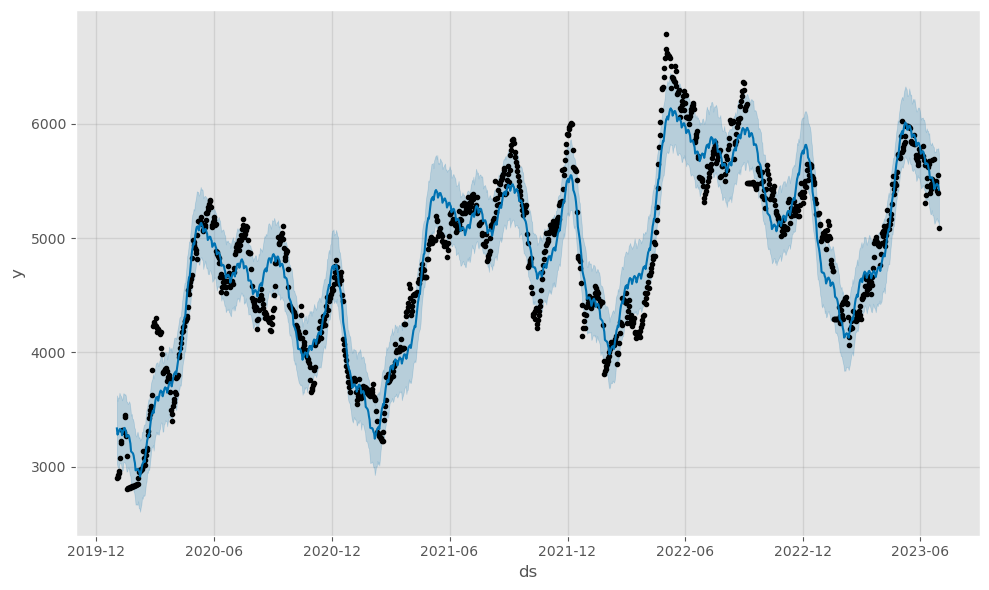

In [9]:
forecast = model.predict(df_train)
model.plot(forecast)
plt.show()

# 미래 날짜 데이터프레임 생성

In [10]:
import datetime


########################################################################################
# datetime.date() 안에 있는 날짜는 리포트의 마지막 날짜를 직접 하드코딩으로 변경해줘야 함.
# base_date : 회차당 분석 일주일 중 마지막 날짜 ex) 2023.03.03 ~ 2023.03.10 중 2023.03.10
# start_date : 과거 6개월의 시작 날짜 ex) 위의 base_date 를 기준으로 했을 때, 2022-09-08
# 아래 calc_days() 함수 내의 end_date 는 미래 6개월의 마지막 날짜 ex) 위의 base_date를 기준으로 했을 때, 2023-09-07
########################################################################################

end_year = int(config['values']['end_date'][:4])
end_month = int(config['values']['end_date'][4:6])
end_day = int(config['values']['end_date'][6:])

def calc_days():
    end_date = datetime.date(end_year, end_month, end_day)
    start_date = datetime.date.today()
    period = end_date - start_date
    return period.days

'''
월요일에 작업하면 +3, 만약 화요일에 작업할 시 +4
'''

fcast_time = calc_days() + 3
print(fcast_time)
forecast1 = model.make_future_dataframe(periods=fcast_time, freq='D')
forecast1 = model.predict(forecast1)

182


# 시각화

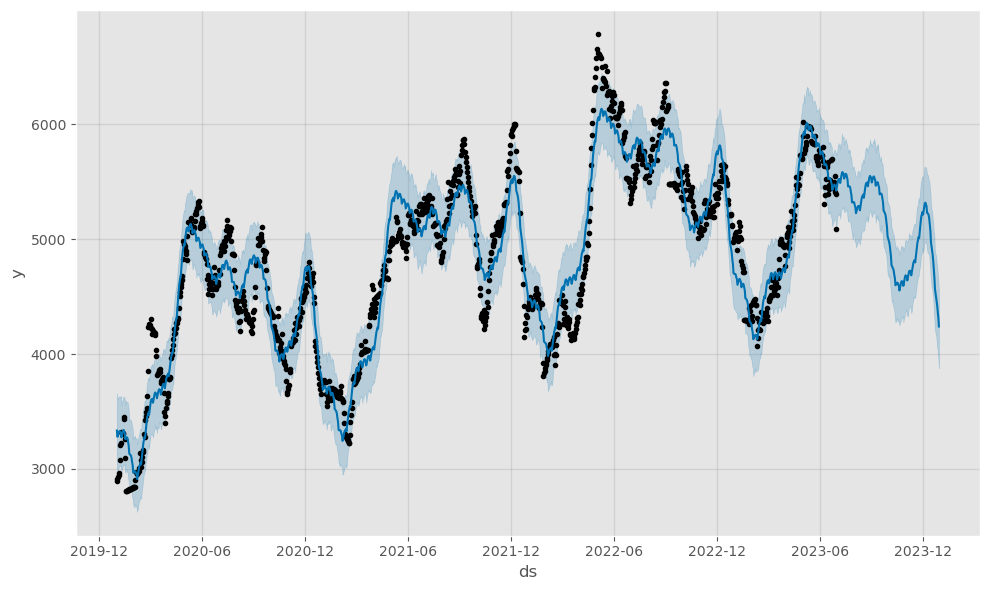

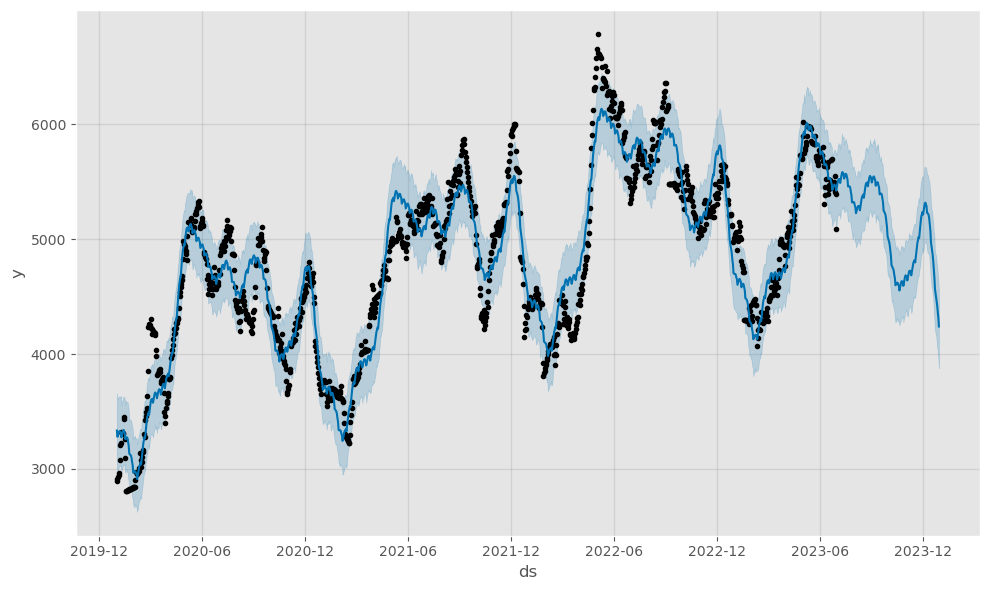

In [11]:
model.plot(forecast1)

# Prophet 예측값 출력

date: 2020-01-02 | predict: 3335
date: 2020-01-03 | predict: 3280
date: 2020-01-04 | predict: 3293
date: 2020-01-05 | predict: 3308
date: 2020-01-06 | predict: 3325
date: 2020-01-07 | predict: 3331
date: 2020-01-08 | predict: 3320
date: 2020-01-09 | predict: 3316
date: 2020-01-10 | predict: 3275
date: 2020-01-11 | predict: 3296
date: 2020-01-12 | predict: 3317
date: 2020-01-13 | predict: 3336
date: 2020-01-14 | predict: 3339
date: 2020-01-15 | predict: 3323
date: 2020-01-16 | predict: 3311
date: 2020-01-17 | predict: 3259
date: 2020-01-18 | predict: 3267
date: 2020-01-19 | predict: 3273
date: 2020-01-20 | predict: 3275
date: 2020-01-21 | predict: 3262
date: 2020-01-22 | predict: 3229
date: 2020-01-23 | predict: 3201
date: 2020-01-24 | predict: 3133
date: 2020-01-25 | predict: 3128
date: 2020-01-26 | predict: 3122
date: 2020-01-27 | predict: 3115
date: 2020-01-28 | predict: 3096
date: 2020-01-29 | predict: 3060
date: 2020-01-30 | predict: 3032
date: 2020-01-31 | predict: 2968
date: 2020

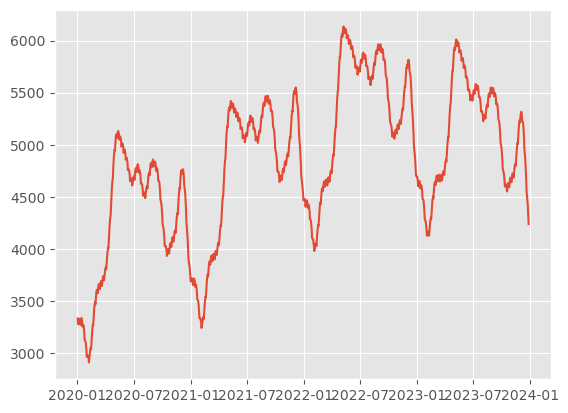

1458


,date,predict
0,2020-01-02,3335
1,2020-01-03,3280
2,2020-01-04,3293
3,2020-01-05,3308
4,2020-01-06,3325
...,...,...
1453,2023-12-25,4463
1454,2023-12-26,4421
1455,2023-12-27,4365
1456,2023-12-28,4319


In [12]:
# 예측값
y_pred = forecast1['yhat'].values
# 날짜
date = forecast1['ds'].values

results = {}
result_date = []
result_price = []
for i in zip(date,y_pred):
    da = str(i[0])[:10]
    predict = round(i[1])
    print('date:', da, '| predict:',predict)
    result_date.append(da)
    result_price.append(predict)
    
results['date'] = result_date
results['predict'] = result_price

plt.plot(date, y_pred)
plt.show()
print(len(result_date))
dataframe = pd.DataFrame(results)
dataframe

In [13]:
dataframe1 = copy.deepcopy(dataframe)
dataframe1['date'] = dataframe['date'].apply(lambda x: x.replace('-','')).astype('int')
dataframe1 = dataframe1[dataframe1['date'] >= int(config['values']['start_date'])]
dataframe1['date'] = dataframe1['date'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
dataframe1

,date,predict
1094,2022-12-31,4699
1095,2023-01-01,4696
1096,2023-01-02,4697
1097,2023-01-03,4689
1098,2023-01-04,4666
...,...,...
1453,2023-12-25,4463
1454,2023-12-26,4421
1455,2023-12-27,4365
1456,2023-12-28,4319


In [14]:
dataframe1['date'] = dataframe1['date'].apply(lambda x:x.replace('-',''))
dataframe1['date'] = dataframe1['date'].astype('int')
dataframe1 = dataframe1[dataframe1['date'] >= int(config['values']['start_date'])].reset_index(drop=True)
dataframe1['date'] = dataframe1['date'].astype('str')
dataframe1['date'] = dataframe1['date'].apply(lambda x : x[:4] + '-' + x[4:6] + '-' +x[6:])
dataframe1

,date,predict
0,2022-12-31,4699
1,2023-01-01,4696
2,2023-01-02,4697
3,2023-01-03,4689
4,2023-01-04,4666
...,...,...
359,2023-12-25,4463
360,2023-12-26,4421
361,2023-12-27,4365
362,2023-12-28,4319


In [15]:
all_day_real_price = all_day_real_price[all_day_real_price['date']>=int(config['values']['start_date'])].reset_index(drop=True)
all_day_real_price['date'] = all_day_real_price['date'].astype('str')
all_day_real_price['date'] = all_day_real_price['date'].apply(lambda x:x[:4] + '-' + x[4:6] + '-' + x[6:])
df_real_price = all_day_real_price[['date', 'auctAmt']]
df_real_price

,date,auctAmt
0,2022-12-31,NaN
1,2023-01-01,NaN
2,2023-01-02,5042.0
3,2023-01-03,5019.0
4,2023-01-04,5066.0
...,...,...
177,2023-06-26,5495.0
178,2023-06-27,5411.0
179,2023-06-28,5551.0
180,2023-06-29,5395.0


In [16]:
df_realtrain['date'] = df_realtrain['date'].apply(lambda x: x.replace('-',''))
df_realtrain['date'] = df_realtrain['date'].astype('int')
df_realtrain = df_realtrain[df_realtrain['date']>=int(config['values']['start_date'])].reset_index(drop=True)
df_realtrain['date'] = df_realtrain['date'].astype('str')
df_realtrain['date'] = df_realtrain['date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
df_auctAmt = df_realtrain[['date', 'auctAmt']]
df_auctAmt

,date,auctAmt
0,2022-12-31,5007.50
1,2023-01-01,5024.75
2,2023-01-02,5042.00
3,2023-01-03,5019.00
4,2023-01-04,5066.00
...,...,...
177,2023-06-26,5495.00
178,2023-06-27,5411.00
179,2023-06-28,5551.00
180,2023-06-29,5395.00


In [17]:
# 분석용 데이터
analysis_df = pd.merge(dataframe1, df_auctAmt, on='date', how = 'outer')
analysis_df

,date,predict,auctAmt
0,2022-12-31,4699,5007.50
1,2023-01-01,4696,5024.75
2,2023-01-02,4697,5042.00
3,2023-01-03,4689,5019.00
4,2023-01-04,4666,5066.00
...,...,...,...
359,2023-12-25,4463,NaN
360,2023-12-26,4421,NaN
361,2023-12-27,4365,NaN
362,2023-12-28,4319,NaN


In [18]:
# 배포용 데이터 
customer_df = pd.merge(dataframe1, df_real_price, on='date', how='outer')
customer_df

,date,predict,auctAmt
0,2022-12-31,4699,NaN
1,2023-01-01,4696,NaN
2,2023-01-02,4697,5042.0
3,2023-01-03,4689,5019.0
4,2023-01-04,4666,5066.0
...,...,...,...
359,2023-12-25,4463,NaN
360,2023-12-26,4421,NaN
361,2023-12-27,4365,NaN
362,2023-12-28,4319,NaN


In [19]:
# 회차정보를 담은 최종 분석용 데이터
analysis_df.to_csv(f'./data/korea/prophet_analysis_{today}_no_param.csv', index=False)

# 회차정보를 담은 최종 고객배포용 데이터
customer_df.to_csv(f'./data/korea/prophet_customer_{today}_no_param.csv', index=False)

In [20]:
# 배포용 데이터의 주차 별 평균값 구하기 (실제가격)
# 7개씩 반복하면서 null값은 제외하고 구할 계획

# dataframe to list 
customer_col = customer_df['auctAmt'].values.tolist()

# 요일을 인덱스로 
# 0 토 1 일 2 월 3 화 4 수 5 목 6 금 
customer_sum = []
customer_avg = []
for index, real_price in enumerate(customer_col):
    if index % 7 == 0:
        sat = real_price
        customer_sum.append(sat)
    elif index % 7 == 1:
        sun = real_price
        customer_sum.append(sun)
    elif index % 7 == 2:
        mon = real_price
        customer_sum.append(mon)
    elif index % 7 == 3:
        tue = real_price
        customer_sum.append(tue)
    elif index % 7 == 4:
        wed = real_price
        customer_sum.append(wed)
    elif index % 7 == 5:
        thu = real_price
        customer_sum.append(thu)
    else:
        fri = real_price
        customer_sum.append(fri)
        
        # nan 값을 삭제 
        newlist = [x for x in customer_sum if pd.isnull(x) == False]
        if len(newlist) != 0:
            avg = sum(newlist)/len(newlist)
            customer_avg.append(avg)
            customer_sum = []
            newlist = []
        else:
            customer_avg.append(0)
            customer_sum = []
            newlist = []
    
customer_avg, len(customer_avg)

([5011.2,
  5017.6,
  4315.166666666667,
  4315.666666666667,
  4370.8,
  4343.4,
  4273.4,
  4302.8,
  4346.8,
  4582.6,
  4598.2,
  4902.4,
  4907.4,
  5032.4,
  5132.0,
  5379.6,
  5609.2,
  5840.5,
  6046.75,
  5862.5,
  5738.0,
  5690.2,
  5630.0,
  5571.6,
  5565.0,
  5388.2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 52)

In [21]:
# 예측가격 컬럼만 리스트로 불러오기 
predict_col = customer_df['predict'].tolist()

# 요일을 인덱스로 
# 0 토 1 일 2 월 3 화 4 수 5 목 6 금 

# 주말 가격 포함
sum_list = []
avg_list = []

# 주말 가격 미포함
sum_list2 =[]
avg_list2 =[]

for index, prd_price in enumerate(predict_col):
    if index % 7 == 0:
        sat = prd_price
        sum_list.append(sat)
    elif index % 7 == 1:
        sun = prd_price
        sum_list.append(sun)
    elif index % 7 == 2:
        mon = prd_price
        sum_list.append(mon)
        sum_list2.append(mon)
    elif index % 7 == 3:
        tue = prd_price
        sum_list.append(tue)
        sum_list2.append(tue)
    elif index % 7 == 4:
        wed = prd_price
        sum_list.append(wed)
        sum_list2.append(wed)
    elif index % 7 == 5:
        thu = prd_price
        sum_list.append(thu)
        sum_list2.append(thu)
    else:
        fri = prd_price
        sum_list.append(fri)
        sum_list2.append(fri)
        avg = sum(sum_list)/len(sum_list)
        # 주말 가격 포함 
        avg_list.append(avg)
        avg_weekday = sum(sum_list2) / len(sum_list2)
        # 주말 가격 제외
        avg_list2.append(avg_weekday)
    
        sum_list = []
        sum_list2 = []

In [22]:
# 주말 가격 포함
avg_list, len(avg_list)

([4671.571428571428,
  4629.571428571428,
  4575.0,
  4417.714285714285,
  4228.428571428572,
  4151.857142857143,
  4248.714285714285,
  4442.571428571428,
  4606.714285714285,
  4679.857142857143,
  4688.857142857143,
  4690.571428571428,
  4723.428571428572,
  4815.714285714285,
  5002.571428571428,
  5291.142857142857,
  5620.428571428572,
  5876.285714285715,
  5981.285714285715,
  5954.142857142857,
  5877.428571428572,
  5806.0,
  5727.285714285715,
  5615.857142857143,
  5502.285714285715,
  5455.428571428572,
  5497.0,
  5556.0,
  5535.0,
  5418.857142857143,
  5296.571428571428,
  5269.285714285715,
  5349.428571428572,
  5460.142857142857,
  5523.285714285715,
  5519.571428571428,
  5465.0,
  5353.714285714285,
  5164.285714285715,
  4918.714285714285,
  4703.142857142857,
  4601.142857142857,
  4611.428571428572,
  4660.714285714285,
  4702.857142857143,
  4779.857142857143,
  4951.142857142857,
  5172.714285714285,
  5282.428571428572,
  5140.142857142857,
  4781.714285714

In [23]:
# 주말 가격 제외
avg_list2, len(avg_list2)

([4661.2,
  4631.0,
  4565.4,
  4393.6,
  4208.8,
  4155.6,
  4275.6,
  4475.4,
  4628.8,
  4688.8,
  4692.2,
  4695.8,
  4734.8,
  4837.8,
  5040.0,
  5341.4,
  5670.0,
  5908.6,
  5990.4,
  5949.0,
  5870.2,
  5800.2,
  5718.2,
  5602.2,
  5492.4,
  5458.8,
  5510.8,
  5565.6,
  5529.0,
  5402.6,
  5287.0,
  5277.0,
  5369.4,
  5478.4,
  5531.8,
  5519.6,
  5458.2,
  5337.4,
  5136.4,
  4886.6,
  4681.8,
  4598.6,
  4621.4,
  4671.4,
  4712.8,
  4799.6,
  4985.6,
  5206.6,
  5288.6,
  5107.0,
  4727.2,
  4361.6],
 52)

In [24]:
avg_info = pd.DataFrame([ x for x in zip(customer_avg,avg_list, avg_list2)], columns = ['avg_auctAmt','avg_predict_all', 'avg_predict_weekday'])

,avg_auctAmt,avg_predict_all,avg_predict_weekday
0,5011.200000,4671.571429,4661.2
1,5017.600000,4629.571429,4631.0
2,4315.166667,4575.000000,4565.4
3,4315.666667,4417.714286,4393.6
4,4370.800000,4228.428571,4208.8
5,4343.400000,4151.857143,4155.6
6,4273.400000,4248.714286,4275.6
7,4302.800000,4442.571429,4475.4
8,4346.800000,4606.714286,4628.8
9,4582.600000,4679.857143,4688.8


In [25]:
# error rate 구하기 
# (predict - auctAmt) / auctAmt

if avg_info['avg_auctAmt'] is not 0:
    avg_info['error_rate'] = (avg_info['avg_predict_weekday']-avg_info['avg_auctAmt'])/avg_info['avg_auctAmt']
else:
    avg_info['error_rate'] = None

avg_info

,avg_auctAmt,avg_predict_all,avg_predict_weekday,error_rate
0,5011.200000,4671.571429,4661.2,-0.069844
1,5017.600000,4629.571429,4631.0,-0.077049
2,4315.166667,4575.000000,4565.4,0.057989
3,4315.666667,4417.714286,4393.6,0.018058
4,4370.800000,4228.428571,4208.8,-0.037064
5,4343.400000,4151.857143,4155.6,-0.043238
6,4273.400000,4248.714286,4275.6,0.000515
7,4302.800000,4442.571429,4475.4,0.040113
8,4346.800000,4606.714286,4628.8,0.064875
9,4582.600000,4679.857143,4688.8,0.023175


In [26]:
# 회차정보를 담은 최종 고객배포용 데이터
avg_info.to_csv(f'./data/korea/error_rate_{today}.csv', index=False)

In [ ]:
# 안녕히 계세요 :)